# Setup & Configuration

## SSL Certificate Fix (macOS)
Run this cell first if you encounter SSL errors when installing packages.

In [23]:
# SSL CERTIFICATE FIX (macOS)
# If you see SSL errors, run this first:
import subprocess
import sys
import ssl
try:
    # Try to fix SSL certificates on macOS
    cert_path = ssl.get_default_verify_paths().openssl_cafile
    print(f"SSL cert location: {cert_path}")
except Exception as e:
    print(f"SSL check: {e}")

# 1. Uninstall the conflicting/deprecated versions first
%pip uninstall -y qiskit qiskit-iqm iqm-client qiskit-machine-learning qiskit-aer

# 2. Install the 2026-supported stack:
#    - qiskit 2.x (latest stable)

#    - qiskit-aer 0.15.x (Qiskit 2.x compatible simulator)
#    - qiskit-machine-learning 0.9.x (Qiskit 2.0 compatibility release)
#    - iqm-client[qiskit] 33.x (includes built-in Qiskit adapter, replaces deprecated qiskit-iqm)
# Note: --trusted-host flags bypass SSL verification as a workaround
%pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org \
             "qiskit>=2.0,<3.0" \
             "qiskit-aer>=0.15.0" \
             "qiskit-machine-learning>=0.9,<0.10" \
             "iqm-client[qiskit]>=33.0,<34.0"

print("✅ Installation complete.")

SSL cert location: /opt/homebrew/etc/openssl@3/cert.pem
Found existing installation: qiskit 2.1.2
Uninstalling qiskit-2.1.2:
  Successfully uninstalled qiskit-2.1.2
Found existing installation: iqm-client 33.0.4
Uninstalling iqm-client-33.0.4:
  Successfully uninstalled iqm-client-33.0.4
Found existing installation: qiskit-machine-learning 0.9.0
Uninstalling qiskit-machine-learning-0.9.0:
  Successfully uninstalled qiskit-machine-learning-0.9.0
Found existing installation: qiskit-aer 0.17.2
Uninstalling qiskit-aer-0.17.2:
  Successfully uninstalled qiskit-aer-0.17.2
Note: you may need to restart the kernel to use updated packages.
  Using cached qiskit-2.3.0-cp310-abi3-macosx_11_0_arm64.whl.metadata (12 kB)
  Using cached qiskit_aer-0.17.2-cp312-cp312-macosx_11_0_arm64.whl.metadata (8.3 kB)
  Using cached qiskit_machine_learning-0.9.0-py3-none-any.whl.metadata (13 kB)
  Using cached iqm_client-33.0.4-py3-none-any.whl.metadata (17 kB)
  Using cached qiskit-2.1.2-cp39-abi3-macosx_11_0_ar

## Required Imports
All necessary libraries for quantum computing, machine learning, and data processing.

In [24]:
# IQM & Qiskit imports
from iqm.qiskit_iqm import IQMProvider
from qiskit import QuantumCircuit, transpile
from qiskit.circuit import ParameterVector
from qiskit.primitives import StatevectorEstimator, PrimitiveResult, PubResult
from qiskit.primitives.base import BaseEstimatorV2
from qiskit.primitives.containers.data_bin import DataBin
from qiskit.quantum_info import SparsePauliOp

# Qiskit Machine Learning
from qiskit_machine_learning.gradients import ParamShiftEstimatorGradient
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.neural_networks import EstimatorQNN

# PyTorch
import torch
import torch.nn as nn

# Data science & ML
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
from ucimlrepo import fetch_ucirepo

# Visualization
import matplotlib.pyplot as plt

# Utilities
import sys
import subprocess
import time


---
# Circuit Definitions

## Hardware-Efficient Ansatz
Custom quantum circuit designed for IQM's star topology (5 qubits, QB3 as central hub).

In [25]:
def ansatz(n_qubits, depth):
    """
    Constructs a hardware-efficient ansatz tailored for a star topology.
    QB3 (index 2) acts as the central hub for entanglement to avoid SWAP gates.
    Native CZ gates are used to minimize decomposition errors.
    """

    # Each full iteration (2 layers) consumes:
    # Layer 1: n_qubits (RY) + 4 (RZ before CZ) = 9 parameters
    # Layer 2: n_qubits (RX) + 4 (RY before CZ) = 9 parameters
    # Total = 18 parameters per iteration (where depth // 2 is the number of iterations)
    params_per_iter = 18
    total_params = params_per_iter * (depth // 2)
    theta = ParameterVector('θ', total_params)

    qc = QuantumCircuit(n_qubits)

    # The loop iterates (depth // 2) times to execute two-layer blocks.
    for j in range(depth // 2):
        offset = j * params_per_iter

        # -------- Layer 1: RY + Star CZ (RZ-based) --------

        # Sub-layer: Independent RY rotations on all qubits
        for i in range(n_qubits):
            qc.ry(theta[offset + i], i)

        # Sub-layer: Entanglement using Star Topology
        # QB3 (index 2) is the central qubit. We connect it to [0, 1, 3, 4].
        # RZ rotations are added to maintain expressibility while using native CZ.
        target_qubits = [0, 1, 3, 4]
        for idx, target in enumerate(target_qubits):
            # Using parameters offset+5 to offset+8
            qc.rz(theta[offset + n_qubits + idx], target)
            qc.cz(2, target)

        # -------- Layer 2: RX + Star CZ (RY-based) --------

        # Move the offset forward for the second layer within the same iteration
        offset_layer2 = offset + 9

        # Sub-layer: Independent RX rotations on all qubits
        for i in range(n_qubits):
            qc.rx(theta[offset_layer2 + i], i)

        # Sub-layer: Entanglement using Star Topology
        # RY rotations are used here to simulate the effect of a CRY-like interaction.
        for idx, target in enumerate(target_qubits):
            # Using parameters offset_layer2+5 to offset_layer2+8
            qc.ry(theta[offset_layer2 + n_qubits + idx], target)
            qc.cz(2, target)

    return qc

## IQM Backend Estimator
Custom estimator class that interfaces with IQM quantum hardware and tracks detailed timing information.

<details>
<summary>📊 Timing Metrics Captured</summary>

- **QPU Execution Time**: Actual quantum circuit execution
- **Compilation Time**: Circuit transpilation and optimization  
- **Queue Time**: Waiting for QPU availability
- **Network Time**: Job upload and result download
- **Total Job Time**: End-to-end execution

</details>

In [26]:
class SimpleIQMJob:
    """A dummy job that simply holds the result."""
    def __init__(self, result):
        self._result = result
    
    def result(self):
        return self._result

# --- THE BRIDGE CLASS ---
class IQMBackendEstimator(BaseEstimatorV2):
    def __init__(self, backend, options=None):
        super().__init__()
        self._backend = backend
        self._options = options or {"shots": 100}
        # collecting timestamps
        self.timestamp_history = []
        self.total_qpu_time = 0.0  # Sum of time on quantum

    def _extract_timestamps(self, result):
        try:
            timeline = result._metadata.get('timeline', [])
            if not timeline:
                return None
            
            timestamps = {}
            for entry in timeline:
                timestamps[entry.status] = entry.timestamp
            
            return timestamps
        except Exception:
            return None

    def run(self, pubs, precision=None):
        if not isinstance(pubs, list): pubs = [pubs]
        job_results = []
        
        # 1. Prepare Circuit
        base_circuit = pubs[0][0]
        circuit_with_meas = base_circuit.copy()
        if circuit_with_meas.num_clbits == 0:
            circuit_with_meas.measure_all()
        
        # 2. Transpile
        transpiled_qc = transpile(circuit_with_meas, self._backend, optimization_level=3)
        
        for pub in pubs:
            _, observables, parameter_values = pub
            if parameter_values.ndim == 1:
                parameter_values = [parameter_values]
            
            pub_expectations = []
            
            for params in parameter_values:
                bound_qc = transpiled_qc.assign_parameters(params)
                
                # 3. Execute on Hardware
                try:
                    job = self._backend.run(bound_qc, shots=self._options["shots"])
                    result = job.result()
                    
                    # ========== TIMESTAMPS (IQM timeline) ==========
                    ts = self._extract_timestamps(result)
                    if ts:
                        exec_start = ts.get('execution_started')
                        exec_end = ts.get('execution_ended')
                        comp_start = ts.get('compilation_started')
                        comp_end = ts.get('compilation_ended')
                        job_created = ts.get('created')
                        job_completed = ts.get('completed')
                        
                        if exec_start and exec_end:
                            execution_time = (exec_end - exec_start).total_seconds()
                            compile_time = (comp_end - comp_start).total_seconds() if comp_start and comp_end else 0
                            job_time = (job_completed - job_created).total_seconds() if job_created and job_completed else 0
                            
                            self.timestamp_history.append({
                                'execution_time_qpu': execution_time,
                                'job_time_total': job_time,
                                'compile_time': compile_time,
                                'raw_timestamps': ts
                            })
                            self.total_qpu_time += execution_time
                            
                            print(f"TIME ON QPU: {execution_time*1000:.2f}ms | "
                                  f"Compilation: {compile_time*1000:.2f}ms | "
                                  f"Job overall: {job_time:.3f}s")
                    # =========================================================
                    
                    counts = result.get_counts()
                    
                    if isinstance(counts, list): counts = counts[0]

                    # 4. Calculate Expectation
                    shots = sum(counts.values())
                    count_0 = 0
                    for bitstring, count in counts.items():
                        if bitstring[-1] == '0':
                            count_0 += count
                    
                    p0 = count_0 / shots
                    p1 = 1 - p0
                    pub_expectations.append(p0 - p1)

                except Exception as e:
                    print(f"Job failed: {e}")
                    pub_expectations.append(0.0)
            
            data = DataBin(evs=np.array(pub_expectations), shape=(len(pub_expectations),))
            job_results.append(PubResult(data=data))

        return SimpleIQMJob(PrimitiveResult(job_results))
    
    def print_timing_summary(self):
        """Detailed summary."""
        if not self.timestamp_history:
            print("Brak danych o timestampach.")
            return
        
        print("\n" + "="*60)
        print("DETAILED SUMMARY OF THE TIMESTAMPS")
        print("="*60)
        print(f"Number of executed jobs: {len(self.timestamp_history)}")
        
        qpu_times = []
        compile_times = []
        queue_times = []
        network_times = []
        
        for t in self.timestamp_history:
            ts = t['raw_timestamps']
            
            # QPU
            if ts.get('execution_started') and ts.get('execution_ended'):
                qpu_times.append((ts['execution_ended'] - ts['execution_started']).total_seconds())
            
            # Compilation
            if ts.get('compilation_started') and ts.get('compilation_ended'):
                compile_times.append((ts['compilation_ended'] - ts['compilation_started']).total_seconds())
            
            # Queue (waiting for QPU)
            if ts.get('pending_execution') and ts.get('execution_started'):
                queue_times.append((ts['execution_started'] - ts['pending_execution']).total_seconds())
            
            # (created->received + ready->completed)
            net_time = 0
            if ts.get('created') and ts.get('received'):
                net_time += (ts['received'] - ts['created']).total_seconds()
            if ts.get('ready') and ts.get('completed'):
                net_time += (ts['completed'] - ts['ready']).total_seconds()
            network_times.append(net_time)
        
        print(f"\nTIME ON QPU :     {sum(qpu_times)*1000:8.2f} ms  (mean: {np.mean(qpu_times)*1000:.2f} ms/job)")
        print(f"Compilation :           {sum(compile_times)*1000:8.2f} ms  (mean: {np.mean(compile_times)*1000:.2f} ms/job)")
        print(f"Queue (wait QPU) :   {sum(queue_times)*1000:8.2f} ms  (mean: {np.mean(queue_times)*1000:.2f} ms/job)")
        print(f"(upload+down) :   {sum(network_times)*1000:8.2f} ms  (mean: {np.mean(network_times)*1000:.2f} ms/job)")
        
        total_measured = sum(qpu_times) + sum(compile_times) + sum(queue_times) + sum(network_times)
        total_job = sum(t['job_time_total'] for t in self.timestamp_history)
        other = total_job - total_measured
        
        print(f"Others (validation etc): {other*1000:8.2f} ms")
        print(f"\nTIME OVERALL:       {total_job*1000:8.2f} ms ({total_job:.3f} s)")
        
        print("\n" + "-"*40)
        print("PERCENTAGE DISTRIBUTION: ")
        print(f"  QPU:        {100*sum(qpu_times)/total_job:5.1f}%")
        print(f"  Compilation: {100*sum(compile_times)/total_job:5.1f}%")
        print(f"  Queue:    {100*sum(queue_times)/total_job:5.1f}%")
        print(f"  Network:       {100*sum(network_times)/total_job:5.1f}%")
        print(f"  Others:       {100*other/total_job:5.1f}%")
        print("="*60 + "\n")

## Hybrid Quantum-Classical Model
PyTorch-based model that integrates quantum circuits with classical neural networks.

In [27]:
"""
    The code below constructs the class HybridModel. It is built using the Qiskit and Pytorch library and
    and utilizes its built-in tools, to create a model connecting classical and quantum computing.

"""

class HybridModel(nn.Module):
    def __init__(self, ansatz_circuit, num_qubits):
        super().__init__()
        self.feature_map = self.angle_encoding(num_qubits)

        # Connecting the quantum circuit. Connecting our feature map (data) and ansatz
        self.qc = QuantumCircuit(num_qubits)
        self.qc.compose(self.feature_map, qubits=range(num_qubits), inplace=True)
        self.qc.compose(ansatz_circuit, inplace=True)

        # Firstly, we inicialize parameters. Our quantum model cannot tell whether the number came from ansatz or feature.
        # That is why here we sort them into two lists. If the number came from feature_map, then it will be a feature and the other way around.
        input_params = list(self.feature_map.parameters)
        weight_params = list(ansatz_circuit.parameters)

        '''
        Measure the Z-operator (spin) on the very first qubit (q_0) and ignore all the other qubits.
        Qiskit reads the string in a reversed order, that is why the Z gate is on the end.
        SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)]) converts string into a mathematical matrix that Qiskit can use for calculations
        Coefficient = 1 is a weight we multiply our result by. In QML it is mostly set to 1
        '''

        observable = SparsePauliOp.from_list([("I" * (num_qubits - 1) + "Z", 1)])

        # Estimator takes ansatz, observables and parameters (data and weights), returns the Expectation value.
        # !!!! CHANGE WHEN USING ON QUANTUM COMPUTER
        # Needed when running quantum simulations, it should be changed when implementing on real quantum computer
        estimator = StatevectorEstimator()

        # Compute the gradients of the sampling probability by the Parameter Shift Rule.
        gradient = ParamShiftEstimatorGradient(estimator)


        '''
        The EstimatorQNN
        This class from Qiskit Machine Learning is used to instantiate the quantum neural network.
        It leverages the Qiskit Primitives (Estimator) to efficiently calculate expectation values
        of the quantum circuit. This allows the model to output continuous, differentiable values (gradients)
        required for backpropagation in hybrid quantum-classical training.
        '''

        self.qnn = EstimatorQNN(
            circuit=self.qc,
            observables=observable,
            input_params=input_params,
            weight_params=weight_params,
            estimator=estimator,
            gradient=gradient
        )

        '''
        TORCH CONNECTOR
        This line initializes the TorchConnector, which serves as a bridge between Qiskit and PyTorch. It wraps the Quantum Neural Network (QNN)
        to make it function as a standard, differentiable PyTorch module (nn.Module).
        This integration allows the quantum parameters to be optimized using standard PyTorch tools like
        the Adam optimizer and automatic differentiation.
        '''
        self.quantum_layer = TorchConnector(self.qnn)

        """
        Creates a Feature Map circuit using Angle Encoding. It maps classical input vectors
        to the quantum space by applying Ry(theta) rotations on each qubit,
        where the rotation angle theta corresponds to the input feature value.
        This effectively encodes the data into the amplitudes of the quantum state
        """

    def angle_encoding(self, num_qubits):
        qc_data = QuantumCircuit(num_qubits)
        input_params = ParameterVector('x', num_qubits)
        for i in range(num_qubits):
            qc_data.ry(input_params[i], i)
        return qc_data

    '''
    This function acts as the main execution path. When the model receives data,
    the forward function passes it into the quantum layer to be processed.
    The quantum layer calculates the result based on the current circuit parameters and returns the prediction.
    '''
    def forward(self, x):
        return self.quantum_layer(x)

---
# Utility Functions

## Helper Functions for Evaluation

<details>
<summary>🔧 Click to view helper function definitions</summary>

The following helper functions simplify common operations:
- **`connect_to_iqm_backend()`**: Manages IQM connection  
- **`load_depth2_data()`**: Loads test data from CSV
- **`load_depth2_weights()`**: Loads pretrained model weights

</details>

In [28]:
# ========================================================
# HELPER FUNCTIONS FOR EVALUATION
# ========================================================
# These functions simplify repeated operations:
# - connect_to_iqm_backend(): IQM connection management
# - load_depth2_data(): Load and cache test data
# - load_depth2_weights(): Load pretrained weights with optional prefix stripping
# ========================================================

def connect_to_iqm_backend():
    """
    Connects to IQM backend if not already connected.
    Returns the backend instance.
    """
    global iqm_backend
    
    if 'iqm_backend' not in globals() or iqm_backend is None:
        print("\n⚠️  IQM backend not found. Connecting...")
        try:
            provider = IQMProvider("https://odra5.e-science.pl/", token=input("Enter IQM Token: "))
            iqm_backend = provider.get_backend()
            print(f"✓ Connected to backend: {iqm_backend.name}")
        except Exception as e:
            print(f"✗ Connection error: {e}")
            raise RuntimeError("Failed to connect to IQM backend") from e
    else:
        print(f"✓ Using existing IQM backend: {iqm_backend.name}")
    
    return iqm_backend


def load_depth2_data():
    """
    Loads depth2/testset.csv if not already loaded.
    Returns (X_test, y_test) as numpy arrays.
    """
    global X_test_depth2, y_test_depth2
    
    if 'X_test_depth2' not in globals():
        try:
            depth2_data = np.loadtxt("depth2/testset.csv", delimiter=",")
            
            if depth2_data.shape[1] != 6:
                raise ValueError(f"Expected 6 columns, got {depth2_data.shape[1]}")
            
            X_test_depth2 = depth2_data[:, :5].astype(np.float32)
            y_test_depth2 = depth2_data[:, 5].astype(np.float32)
            
            print(f"✓ Loaded depth2 testset: {X_test_depth2.shape[0]} samples")
        except Exception as e:
            print(f"✗ Error loading testset: {e}")
            raise
    else:
        print(f"✓ Using existing depth2 testset: {X_test_depth2.shape[0]} samples")
    
    return X_test_depth2, y_test_depth2


def load_depth2_weights(model, strip_prefix=False):
    """
    Loads weights from depth2/model_checkpoint_epoch_22.pth into model.
    
    Args:
        model: The model to load weights into
        strip_prefix: If True, strips "quantum_layer." prefix from keys
                     (needed when loading HybridModel weights into TorchConnector)
    """
    try:
        loaded_state = torch.load("depth2/model_checkpoint_epoch_22.pth")
        
        if strip_prefix:
            # Strip "quantum_layer." prefix from keys
            adjusted_state = {}
            for key, value in loaded_state.items():
                if key.startswith("quantum_layer."):
                    new_key = key.replace("quantum_layer.", "", 1)
                    adjusted_state[new_key] = value
                else:
                    adjusted_state[key] = value
            loaded_state = adjusted_state
        
        model.load_state_dict(loaded_state)
        print("✓ Loaded weights from depth2/model_checkpoint_epoch_22.pth")
        
    except Exception as e:
        print(f"✗ Error loading weights: {e}")
        raise

print("✓ Helper functions defined")

✓ Helper functions defined


---
# Model Setup

## Initialize Quantum Model
Create a 5-qubit model with depth-2 ansatz for evaluation.

In [29]:
# Initializing the model with 5 qubits
num_qubits = 5
final_ansatz = ansatz(num_qubits, 2)
model = HybridModel(final_ansatz, num_qubits)

---
# Evaluation Experiments

## Shot Count Comparison Analysis
Compare model accuracy and performance across different shot counts on IQM hardware vs StatevectorEstimator baseline.

**What this cell does:**
1. Prompts for shot counts and sample size
2. Evaluates baseline with StatevectorEstimator  
3. Tests multiple shot configurations on IQM hardware
4. Generates comparison graphs
5. Displays results summary table


SHOT COUNT COMPARISON ANALYSIS - IQM vs StatevectorEstimator


Enter shot counts (comma-separated, e.g., 10,50,100,500,1000):  1,10,100


✓ Testing shot counts: [1, 10, 100]


Enter number of samples to test (max 275):  25


✓ Using 25 samples from depth2 testset

✓ Using existing depth2 testset: 275 samples
✓ Selected random subset of 25 samples (seed=42)

----------------------------------------------------------------------
Evaluating StatevectorEstimator baseline...
----------------------------------------------------------------------
✓ Loaded weights from depth2/model_checkpoint_epoch_22.pth
✓ Statevector Accuracy: 0.8000 (80.00%)
✓ Statevector Time: 0.0451s

----------------------------------------------------------------------
Evaluating IQM Hardware with varying shot counts...
----------------------------------------------------------------------
✓ Using existing IQM backend: IQMBackend




Evaluating shot counts:   0%|                         | 0/3 [00:00<?, ?config/s]No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


✓ Loaded weights from depth2/model_checkpoint_epoch_22.pth
TIME ON QPU: 133.09ms | Compilation: 103.69ms | Job overall: 2.285s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 107.19ms | Compilation: 88.88ms | Job overall: 2.197s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 100.95ms | Compilation: 62.67ms | Job overall: 2.208s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 100.53ms | Compilation: 196.41ms | Job overall: 2.206s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 128.14ms | Compilation: 151.23ms | Job overall: 2.204s
TIME ON QPU: 105.27ms | Compilation: 120.82ms | Job overall: 2.227s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 106.37ms | Compilation: 127.00ms | Job overall: 2.214s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 130.22ms | Compilation: 64.15ms | Job overall: 2.210s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 105.72ms | Compilation: 85.53ms | Job overall: 2.206s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 101.75ms | Compilation: 193.43ms | Job overall: 2.211s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 101.29ms | Compilation: 175.16ms | Job overall: 2.206s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 130.88ms | Compilation: 184.52ms | Job overall: 2.217s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 105.09ms | Compilation: 154.08ms | Job overall: 2.197s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 134.09ms | Compilation: 69.24ms | Job overall: 2.205s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 554.51ms | Compilation: 68.52ms | Job overall: 2.214s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 134.47ms | Compilation: 183.05ms | Job overall: 2.205s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 129.31ms | Compilation: 172.55ms | Job overall: 2.210s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 101.20ms | Compilation: 141.21ms | Job overall: 2.214s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 121.76ms | Compilation: 64.22ms | Job overall: 2.205s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 129.62ms | Compilation: 200.18ms | Job overall: 2.211s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 132.21ms | Compilation: 63.53ms | Job overall: 2.208s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 101.90ms | Compilation: 91.35ms | Job overall: 2.480s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 120.72ms | Compilation: 154.90ms | Job overall: 2.219s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 132.55ms | Compilation: 104.52ms | Job overall: 2.207s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]

Evaluating shot counts:   0%| | 0/3 [01:30<?, ?config/s, shots=1, acc=0.5600, QP
Evaluating shot counts:  33%|▎| 1/3 [01:30<03:01, 90.92s/config, shots=1, acc=0.No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


TIME ON QPU: 134.01ms | Compilation: 200.91ms | Job overall: 2.198s
✓ Loaded weights from depth2/model_checkpoint_epoch_22.pth




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 133.75ms | Compilation: 211.10ms | Job overall: 2.205s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 104.29ms | Compilation: 66.64ms | Job overall: 2.208s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 138.43ms | Compilation: 186.46ms | Job overall: 2.208s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 107.88ms | Compilation: 155.42ms | Job overall: 2.210s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 134.25ms | Compilation: 122.94ms | Job overall: 2.211s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 105.50ms | Compilation: 127.85ms | Job overall: 2.215s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 105.16ms | Compilation: 91.37ms | Job overall: 2.196s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 139.32ms | Compilation: 207.92ms | Job overall: 2.205s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 105.21ms | Compilation: 65.71ms | Job overall: 2.211s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 111.51ms | Compilation: 50.40ms | Job overall: 2.237s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 105.64ms | Compilation: 193.47ms | Job overall: 2.208s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 97.69ms | Compilation: 89.00ms | Job overall: 2.206s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 138.66ms | Compilation: 63.57ms | Job overall: 2.201s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 104.67ms | Compilation: 223.34ms | Job overall: 2.204s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 130.69ms | Compilation: 219.38ms | Job overall: 2.208s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 133.32ms | Compilation: 172.22ms | Job overall: 2.209s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 134.94ms | Compilation: 121.33ms | Job overall: 2.212s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 103.63ms | Compilation: 77.34ms | Job overall: 2.211s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 138.34ms | Compilation: 187.82ms | Job overall: 2.285s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 138.43ms | Compilation: 84.98ms | Job overall: 2.206s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 102.64ms | Compilation: 165.41ms | Job overall: 2.201s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 105.75ms | Compilation: 106.07ms | Job overall: 2.207s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 107.75ms | Compilation: 88.93ms | Job overall: 2.200s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 108.07ms | Compilation: 101.60ms | Job overall: 2.203s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]

Evaluating shot counts:  33%|▎| 1/3 [03:02<03:01, 90.92s/config, shots=10, acc=0
Evaluating shot counts:  67%|▋| 2/3 [03:02<01:31, 91.41s/config, shots=10, acc=0No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


TIME ON QPU: 123.38ms | Compilation: 131.29ms | Job overall: 2.202s
✓ Loaded weights from depth2/model_checkpoint_epoch_22.pth




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 147.14ms | Compilation: 154.90ms | Job overall: 2.458s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:03<?, ?it/s]


TIME ON QPU: 134.98ms | Compilation: 185.14ms | Job overall: 2.211s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 181.96ms | Compilation: 182.35ms | Job overall: 2.207s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 163.10ms | Compilation: 97.79ms | Job overall: 2.206s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 181.53ms | Compilation: 222.20ms | Job overall: 2.211s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 166.61ms | Compilation: 196.26ms | Job overall: 2.206s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 146.48ms | Compilation: 89.49ms | Job overall: 2.205s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 172.46ms | Compilation: 64.02ms | Job overall: 2.203s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 146.67ms | Compilation: 91.23ms | Job overall: 2.203s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 154.72ms | Compilation: 67.17ms | Job overall: 2.205s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 173.55ms | Compilation: 131.98ms | Job overall: 2.204s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 183.02ms | Compilation: 58.54ms | Job overall: 2.184s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 181.09ms | Compilation: 221.54ms | Job overall: 2.207s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 170.20ms | Compilation: 314.52ms | Job overall: 2.208s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 185.09ms | Compilation: 102.68ms | Job overall: 2.208s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 169.72ms | Compilation: 220.49ms | Job overall: 2.209s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 174.22ms | Compilation: 59.43ms | Job overall: 2.208s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 181.82ms | Compilation: 154.26ms | Job overall: 2.215s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 160.09ms | Compilation: 120.65ms | Job overall: 2.191s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 186.55ms | Compilation: 187.46ms | Job overall: 2.202s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 184.85ms | Compilation: 52.25ms | Job overall: 2.212s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 184.95ms | Compilation: 49.71ms | Job overall: 2.204s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 183.62ms | Compilation: 163.17ms | Job overall: 2.209s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]


TIME ON QPU: 178.48ms | Compilation: 156.74ms | Job overall: 2.204s




Progress in queue:   0%|                                  | 0/1 [00:00<?, ?it/s]

Progress in queue:   0%|                                  | 0/1 [00:02<?, ?it/s]

Evaluating shot counts:  67%|▋| 2/3 [04:33<01:31, 91.41s/config, shots=100, acc=
Evaluating shot counts: 100%|█| 3/3 [04:33<00:00, 91.12s/config, shots=100, acc=

TIME ON QPU: 183.46ms | Compilation: 97.86ms | Job overall: 2.200s

✓ Hardware evaluation complete!

----------------------------------------------------------------------
Generating comparison graphs...
----------------------------------------------------------------------



Exception ignored in: <function tqdm.__del__ at 0x113215440>
Traceback (most recent call last):
  File "/Users/jkw/Documents/uni/axion/QC1/.venv/lib/python3.12/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/jkw/Documents/uni/axion/QC1/.venv/lib/python3.12/site-packages/tqdm/notebook.py", line 277, in close
    self.disp(bar_style='danger', check_delay=False)
    ^^^^^^^^^
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


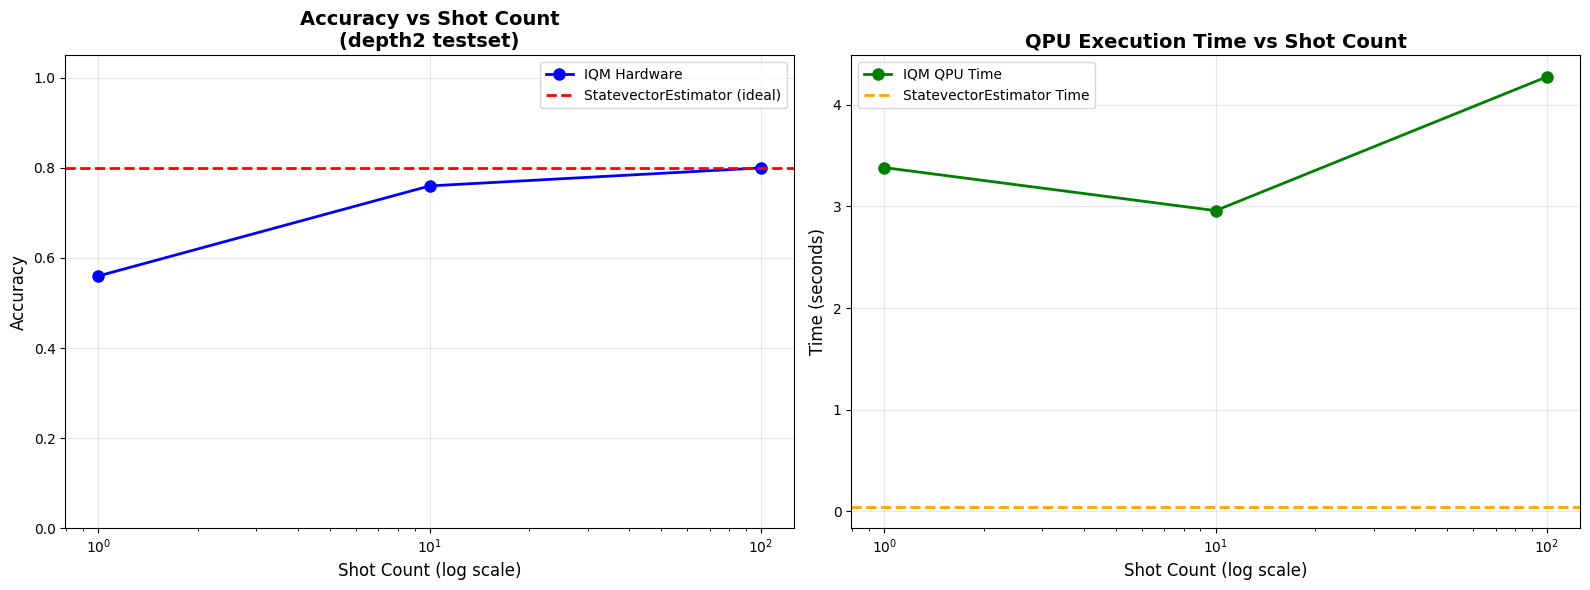


RESULTS SUMMARY
Shot Count      | Accuracy   | QPU Time (s)   
----------------------------------------------------------------------
Statevector     | 0.8000     | 0.0451         
1               | 0.5600     | 3.38           
10              | 0.7600     | 2.96           
100             | 0.8000     | 4.28           


In [35]:
# ========================================================
# Shot Count Comparison Analysis
# ========================================================

print("\n" + "=" * 70)
print("SHOT COUNT COMPARISON ANALYSIS - IQM vs StatevectorEstimator")
print("=" * 70)

# Import tqdm for progress bar
# Try regular tqdm first (works in most environments)
try:
    from tqdm import tqdm
    has_tqdm = True
except ImportError:
    has_tqdm = False
    print("⚠️  tqdm not installed. Install with: pip install tqdm")
    print("Continuing with simple progress output...\n")

# ========================================================
# A. Input Collection
# ========================================================

# Prompt for shot counts
try:
    shot_input = input("Enter shot counts (comma-separated, e.g., 10,50,100,500,1000): ")
    shot_counts = [int(s.strip()) for s in shot_input.split(",")]
    
    # Validate all shots are positive
    if any(n <= 0 for n in shot_counts):
        raise ValueError("All shot counts must be positive integers")
    
    # Sort for better visualization
    shot_counts = sorted(shot_counts)
    
    print(f"✓ Testing shot counts: {shot_counts}")
    
except ValueError as e:
    print(f"✗ Invalid shot input: {e}")
    raise

# Prompt for sample size
try:
    sample_input = input(f"Enter number of samples to test (max 275): ")
    n_samples = int(sample_input)
    
    if n_samples <= 0:
        raise ValueError("Sample count must be positive")
    if n_samples > 275:
        raise ValueError("Sample count cannot exceed 275 (testset size)")
    
    print(f"✓ Using {n_samples} samples from depth2 testset\n")
    
except ValueError as e:
    print(f"✗ Invalid sample input: {e}")
    raise

# ========================================================
# B. Data Preparation
# ========================================================

# Load depth2 test dataset
X_test_depth2_full, y_test_depth2_full = load_depth2_data()

# Select samples
if n_samples < len(X_test_depth2_full):
    # Random subset with fixed seed for reproducibility
    np.random.seed(42)
    indices = np.random.choice(len(X_test_depth2_full), size=n_samples, replace=False)
    X_test_depth2_subset = X_test_depth2_full[indices]
    y_test_depth2_subset = y_test_depth2_full[indices]
    print(f"✓ Selected random subset of {n_samples} samples (seed=42)")
else:
    X_test_depth2_subset = X_test_depth2_full
    y_test_depth2_subset = y_test_depth2_full
    print(f"✓ Using full testset ({n_samples} samples)")

# ========================================================
# C. Baseline Evaluation (StatevectorEstimator)
# ========================================================

print("\n" + "-" * 70)
print("Evaluating StatevectorEstimator baseline...")
print("-" * 70)

# Build depth2 model with StatevectorEstimator
depth2_ansatz_sv = ansatz(5, 2)
depth2_model_sv = HybridModel(depth2_ansatz_sv, 5)

# Load depth2 weights
load_depth2_weights(depth2_model_sv, strip_prefix=False)
depth2_model_sv.eval()

# Evaluate with timing
X_test_tensor = torch.tensor(X_test_depth2_subset, dtype=torch.float32)

start_time = time.time()
with torch.no_grad():
    sv_predictions = depth2_model_sv(X_test_tensor).numpy().flatten()
sv_time = time.time() - start_time

sv_predicted_labels = np.where(sv_predictions > 0, 1, -1)
sv_accuracy = accuracy_score(y_test_depth2_subset, sv_predicted_labels)

print(f"✓ Statevector Accuracy: {sv_accuracy:.4f} ({sv_accuracy*100:.2f}%)")
print(f"✓ Statevector Time: {sv_time:.4f}s\n")

# ========================================================
# D. Hardware Evaluation Loop
# ========================================================

print("-" * 70)
print("Evaluating IQM Hardware with varying shot counts...")
print("-" * 70)

# Connect to IQM backend
iqm_backend = connect_to_iqm_backend()
print()  # Add spacing

# Store results
hw_results = []

# Progress bar setup
if has_tqdm:
    pbar = tqdm(shot_counts, desc="Evaluating shot counts", unit="config")
else:
    pbar = shot_counts
    print(f"Progress: 0/{len(shot_counts)} shot configurations completed")

for idx, n_shots in enumerate(pbar):
    try:
        # Build hardware estimator
        hw_estimator = IQMBackendEstimator(iqm_backend, options={"shots": n_shots})
        
        # Build depth2 quantum circuit for hardware
        hw_ansatz = ansatz(5, 2)
        hw_feature_map = HybridModel(hw_ansatz, 5).angle_encoding(5)
        
        hw_qc = QuantumCircuit(5)
        hw_qc.compose(hw_feature_map, qubits=range(5), inplace=True)
        hw_qc.compose(hw_ansatz, inplace=True)
        
        observable = SparsePauliOp.from_list([("I" * 4 + "Z", 1)])
        
        hw_qnn = EstimatorQNN(
            circuit=hw_qc,
            observables=observable,
            input_params=list(hw_feature_map.parameters),
            weight_params=list(hw_ansatz.parameters),
            estimator=hw_estimator
        )
        
        hw_model = TorchConnector(hw_qnn)
        
        # Load weights with prefix stripping
        load_depth2_weights(hw_model, strip_prefix=True)
        
        # Run inference
        with torch.no_grad():
            hw_predictions = hw_model(X_test_tensor).numpy().flatten()
        
        hw_predicted_labels = np.where(hw_predictions > 0, 1, -1)
        hw_accuracy = accuracy_score(y_test_depth2_subset, hw_predicted_labels)
        hw_qpu_time = hw_estimator.total_qpu_time / n_samples  # Average per sample
        
        # Store results (QPU time is average per sample)
        hw_results.append({
            'shots': n_shots,
            'accuracy': hw_accuracy,
            'qpu_time': hw_qpu_time  # Average time per sample
        })
        
        # Update progress
        if has_tqdm:
            pbar.set_postfix({
                'shots': n_shots,
                'acc': f'{hw_accuracy:.4f}',
                'QPU_time': f'{hw_qpu_time:.4f}s'  # Changed format for smaller numbers
            })
        else:
            print(f"Progress: {idx+1}/{len(shot_counts)} | shots={n_shots} | acc={hw_accuracy:.4f} | QPU_time_per_sample={hw_qpu_time:.4f}s")
            
    except Exception as e:
        print(f"\n✗ Error at {n_shots} shots: {e}")
        # Continue with other shot counts
        hw_results.append({
            'shots': n_shots,
            'accuracy': None,
            'qpu_time': None
        })

print("\n✓ Hardware evaluation complete!\n")

# ========================================================
# E. Visualization
# ========================================================

print("-" * 70)
print("Generating comparison graphs...")
print("-" * 70)

# Extract data for plotting
hw_shots = [r['shots'] for r in hw_results if r['accuracy'] is not None]
hw_accuracies = [r['accuracy'] for r in hw_results if r['accuracy'] is not None]
hw_times = [r['qpu_time'] for r in hw_results if r['qpu_time'] is not None]

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Figure 1: Shot Count vs Accuracy
ax1.plot(hw_shots, hw_accuracies, 'o-', color='blue', linewidth=2, markersize=8, label='IQM Hardware')
ax1.axhline(y=sv_accuracy, color='red', linestyle='--', linewidth=2, label='StatevectorEstimator (ideal)')
ax1.set_xscale('log')
ax1.set_xlabel('Shot Count (log scale)', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Accuracy vs Shot Count\n(depth2 testset)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1.05])

# Figure 2: Shot Count vs QPU Time
ax2.plot(hw_shots, hw_times, 'o-', color='green', linewidth=2, markersize=8, label='IQM QPU Time')
ax2.axhline(y=sv_time, color='orange', linestyle='--', linewidth=2, label='StatevectorEstimator Time')
ax2.set_xscale('log')
ax2.set_xlabel('Shot Count (log scale)', fontsize=12)
ax2.set_ylabel('Time (seconds)', fontsize=12)
ax2.set_title('Average QPU Time per Sample vs Shot Count', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# ========================================================
# F. Summary Table
# ========================================================

print("\n" + "=" * 70)
print("RESULTS SUMMARY")
print("=" * 70)
print(f"{'Shot Count':<15} | {'Accuracy':<10} | {'Avg QPU Time/sample (s)':<25}")
print("-" * 70)
print(f"{'Statevector':<15} | {sv_accuracy:<10.4f} | {sv_time:<25.4f}")
for result in hw_results:
    if result['accuracy'] is not None:
        print(f"{result['shots']:<15} | {result['accuracy']:<10.4f} | {result['qpu_time']:<25.4f}")
    else:
        print(f"{result['shots']:<15} | {'FAILED':<10} | {'N/A':<25}")
print("=" * 70)

## IQM Job Timing Distribution
Visualize how time is distributed across different components of IQM job execution (QPU, compilation, queue, network, overhead).


IQM JOB TIMING BREAKDOWN

Available shot counts: [1, 10, 100]


Enter shot count to analyze timing (or press Enter for last):  100



Number of jobs: 25
Total job time: 55.382s

Time Breakdown:
  QPU Execution:     4276.35 ms  (  7.7%)
  Compilation:       3441.83 ms  (  6.2%)
  Queue (waiting):    255.97 ms  (  0.5%)
  Network (I/O):    18466.10 ms  ( 33.3%)
  Other (overhead): 28941.47 ms  ( 52.3%)


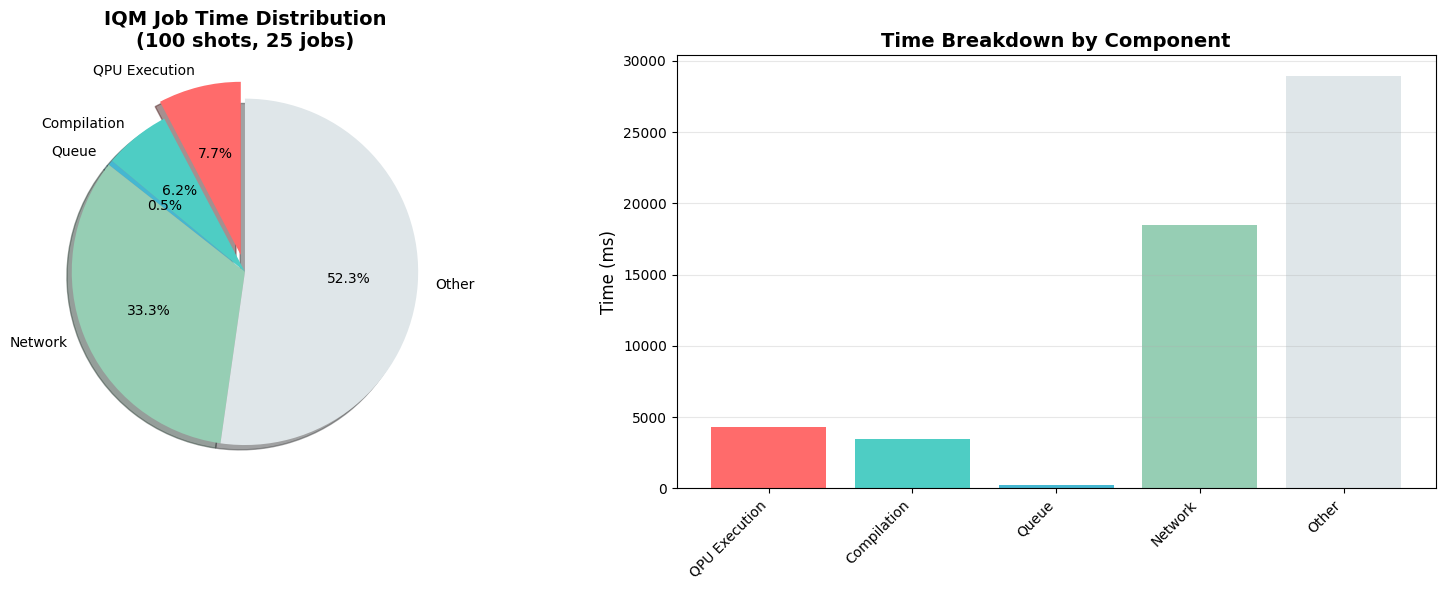

In [37]:
# ========================================================
# IQM Job Timing Distribution Analysis
# ========================================================

print("\n" + "=" * 70)
print("IQM JOB TIMING BREAKDOWN")
print("=" * 70)

# Select which shot count configuration to analyze
print("\nAvailable shot counts:", [r['shots'] for r in hw_results if r['accuracy'] is not None])
selected_shots = int(input("Enter shot count to analyze timing (or press Enter for last): ") or hw_results[-1]['shots'])

# Find the corresponding estimator from the last evaluation loop
# Note: We need to re-run evaluation or store estimators to access timing data
# For now, we'll use the last hw_estimator from the loop

if not hasattr(hw_estimator, 'timestamp_history') or not hw_estimator.timestamp_history:
    print("⚠️  No timing data available. Run the evaluation first.")
else:
    # Extract timing data
    qpu_times = []
    compile_times = []
    queue_times = []
    network_times = []
    
    for t in hw_estimator.timestamp_history:
        ts = t['raw_timestamps']
        
        # QPU execution time
        if ts.get('execution_started') and ts.get('execution_ended'):
            qpu_times.append((ts['execution_ended'] - ts['execution_started']).total_seconds())
        
        # Compilation time
        if ts.get('compilation_started') and ts.get('compilation_ended'):
            compile_times.append((ts['compilation_ended'] - ts['compilation_started']).total_seconds())
        
        # Queue time (waiting for QPU)
        if ts.get('pending_execution') and ts.get('execution_started'):
            queue_times.append((ts['execution_started'] - ts['pending_execution']).total_seconds())
        
        # Network time (upload + download)
        net_time = 0
        if ts.get('created') and ts.get('pending_compilation'):
            net_time += (ts['pending_compilation'] - ts['created']).total_seconds()
        if ts.get('ready') and ts.get('completed'):
            net_time += (ts['completed'] - ts['ready']).total_seconds()
        network_times.append(net_time)
    
    # Calculate totals
    total_qpu = sum(qpu_times)
    total_compile = sum(compile_times)
    total_queue = sum(queue_times)
    total_network = sum(network_times)
    total_job = sum(t['job_time_total'] for t in hw_estimator.timestamp_history)
    total_other = total_job - (total_qpu + total_compile + total_queue + total_network)
    
    # Print summary
    print(f"\nNumber of jobs: {len(hw_estimator.timestamp_history)}")
    print(f"Total job time: {total_job:.3f}s")
    print("\nTime Breakdown:")
    print(f"  QPU Execution:    {total_qpu*1000:8.2f} ms  ({100*total_qpu/total_job:5.1f}%)")
    print(f"  Compilation:      {total_compile*1000:8.2f} ms  ({100*total_compile/total_job:5.1f}%)")
    print(f"  Queue (waiting):  {total_queue*1000:8.2f} ms  ({100*total_queue/total_job:5.1f}%)")
    print(f"  Network (I/O):    {total_network*1000:8.2f} ms  ({100*total_network/total_job:5.1f}%)")
    print(f"  Other (overhead): {total_other*1000:8.2f} ms  ({100*total_other/total_job:5.1f}%)")
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Pie chart
    labels = ['QPU Execution', 'Compilation', 'Queue', 'Network', 'Other']
    sizes = [total_qpu, total_compile, total_queue, total_network, total_other]
    colors = ['#ff6b6b', '#4ecdc4', '#45b7d1', '#96ceb4', '#dfe6e9']
    explode = (0.1, 0, 0, 0, 0)  # Emphasize QPU
    
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.set_title(f'IQM Job Time Distribution\n({selected_shots} shots, {len(hw_estimator.timestamp_history)} jobs)', 
                  fontsize=14, fontweight='bold')
    
    # Bar chart
    ax2.bar(labels, [s*1000 for s in sizes], color=colors)
    ax2.set_ylabel('Time (ms)', fontsize=12)
    ax2.set_title('Time Breakdown by Component', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3, axis='y')
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()
    
    print("\n" + "=" * 70)